# Image Classification Models using Tensorflow, Donkey vs Zebra vs Horse
This jupyter notebook demonstrates how to build a model to classify three categories (“donkey”, “zebra”, or “horse”) by utilizing Image Augmentation and Transfer Learning.

## Import Libraries

In [1]:
# opendatasets is a Python library for downloading datasets from online sources like Kaggle.
# Follow this link for details, https://pypi.org/project/opendatasets/
%pip install opendatasets

In [2]:
# Import required libraries
import opendatasets as od
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.preprocessing import image
import tensorflow_hub as hub

## Data Preparation

### Get Data from Kaggle

In [3]:
# Run this cell to download dataset
dataset_url = "https://www.kaggle.com/datasets/ifeanyinneji/donkeys-horses-zebra-images-dataset"
od.download(dataset_url)

Skipping, found downloaded files in "./donkeys-horses-zebra-images-dataset" (use force=True to force download)


### Restructure Data

#### Load Data
This dataset contains about 1.2K 224x224px quality animal images belonging to 3 categories: horse, zebra and donkeys. The main directory is divided into folders; train and test and then one folder for each category. Image count for each category varies from 200 to 500 images.

Source: [Kaggle - Donkeys, Horses & Zebra Images Dataset](https://www.kaggle.com/datasets/ifeanyinneji/donkeys-horses-zebra-images-dataset/data)

In [4]:
# Define initial folder directory
src_colab_dataset = "/content/donkeys-horses-zebra-images-dataset"
print(*list(os.walk(src_colab_dataset)), sep = "\n")

('/content/donkeys-horses-zebra-images-dataset', ['test', 'train'], ['names_labels.csv'])
('/content/donkeys-horses-zebra-images-dataset/test', ['zebra', 'horse', 'donkey'], [])
('/content/donkeys-horses-zebra-images-dataset/test/zebra', [], ['zebra (40).jpg', 'zebra (14).jpg', 'zebra (11).jpg', 'zebra (21).jpg', 'zebra (52).jpg', 'zebra (44).jpg', 'zebra (46).jpg', 'zebra (50).jpg', 'zebra (22).jpg', 'zebra (24).jpg', 'zebra (48).jpg', 'zebra (3).jpg', 'zebra (29).jpg', 'zebra (23).jpg', 'zebra (12).jpg', 'zebra (51).jpg', 'zebra (4).jpg', 'zebra (43).jpg', 'zebra (36).jpg', 'zebra (49).jpg', 'zebra (10).jpg', 'zebra (27).jpg', 'zebra (13).jpg', 'zebra (31).jpg', 'zebra (41).jpg', 'zebra (16).jpg', 'zebra (55).jpg', 'zebra (62).jpg', 'zebra (7).jpg', 'zebra (15).jpg', 'zebra (28).jpg', 'zebra (6).jpg', 'zebra (17).jpg', 'zebra (20).jpg', 'zebra (33).jpg', 'zebra (30).jpg', 'zebra (5).jpg', 'zebra (37).JPG', 'zebra (35).jpg', 'zebra (38).JPG', 'zebra (26).jpg', 'zebra (57).jpg', 'zebra

#### Merge Again Data
In this experiment, each image in the "donkey", "zebra", and "horse" folders in "train" and "test" will be merged into one folder for each category; “donkey”, “zebra”, and “horse”.

The following is the function used to merge the "donkey", "zebra", and "horse" folders. The following function created by Nehal Shaikh fits this goal. This function can be accessed from [How To Merge Directories Using Python Functions](https://nehals4545.medium.com/how-to-merge-folders-using-python-functions-727b7e03261a).

In [5]:
# Funtion for merge dataset
# define a function & pass dst. directory and src. directories
def merge_directories(new_directory_name, *directories_to_merge):
    if not os.path.exists(new_directory_name):
        os.makedirs(new_directory_name) # create a dst. directory if not exist

    for directory in directories_to_merge:
        for item in os.listdir(directory): # iterate sub-directory from source folders
            # join path of folder and sub-folder
            s = os.path.join(directory, item)
            d = os.path.join(new_directory_name, item)
            if os.path.isdir(s):
                if item in os.listdir(new_directory_name):
                    files = os.listdir(s)
                    for file in files: # iterate file from sub-folder
                        j = os.path.join(s, file)
                        k = os.path.join(d, file)
                        shutil.copy2(j,k) # paste file in already existed sub-directory
                else:
                    shutil.copytree(s, d) # create a sub-directory in dst directory then paste file
            else:
                shutil.copy2(s, d) # paste file in already existed sub-directory

In [6]:
# Defines a new folder where the merged "donkey", "zebra", and "horse" folders are stored
des_colab_dataset_dir = "/content/donkeys-horses-zebra-images-dataset-merged"

# "train" and "test" folders of src_colab_dataset
src_colab_dataset_train = os.path.join(src_colab_dataset, "train")
src_colab_dataset_test = os.path.join(src_colab_dataset, "test")
merge_directories(des_colab_dataset_dir, src_colab_dataset_train, src_colab_dataset_test)

#### Split Again to Train, Validation, and Test

The initial folder has the following structure.

* donkey-image-merged-zebra-horse data set
 * donkey
 * horse
 * zebras

The initial folder will be divided into new folders with the following structure.
* donkey-split-zebra-image-dataset
  * train
    * donkey
    * horse
    * zebras
  * val
    * donkey
    * horse
    * zebras
  * test
    * donkey
    * horse
    * zebras

Each of the "donkey", "zebra", and "horse" images in the new train, val, and test folders will be divided by a composition of 75%/15%/10% (train/test/validation).

Source: [How to split image dataset into train, validation and test set?](https://aravinda-gn.medium.com/how-to-split-image-dataset-into-train-validation-and-test-set-5a41c48af332)




In [7]:
def copy_dir2_train_val_test(src_dir, dataset_type, des_train_val_test_dir, ratio_train_val_test):
  folder_dir = os.path.join(src_dir, dataset_type)
  imgs_list = [filename for filename in os.listdir(folder_dir) if os.path.getsize(folder_dir)]

  # Sets the random seed
  # A random seed is used to ensure that results are reproducible.
  # In other words, using this parameter makes sure that anyone who
  # re-runs your code will get the exact same outputs. Reproducibility
  # is an extremely important concept in data science and other fields.
  random.seed(2)

  # Shuffle the list of image filenames
  random.shuffle(imgs_list)

  # determine the number of images for each set
  train_size = int(len(imgs_list) * ratio_train_val_test[0])
  val_size = int(len(imgs_list) * ratio_train_val_test[1])
  test_size = len(imgs_list) - train_size - val_size

  # Copy image files to destination folders
  for i, f in enumerate(imgs_list):
    if i < train_size:
      dest_folder = des_train_val_test_dir[0]
    elif i < train_size + val_size:
      dest_folder = des_train_val_test_dir[1]
    else:
      dest_folder = des_train_val_test_dir[2]

    shutil.copy(
        os.path.join(src_dir, dataset_type, f),
        os.path.join(dest_folder, dataset_type, f)
        )

In [8]:
# Split source data to training, validation, and test data
def split_data(src_dir, des_dir, train_val_test_ratio):
  if sum(train_val_test_ratio) != 1:
    return "Sum of ratio must be 1"

  # -- Create directory if not exist
  if not os.path.exists(des_dir):
    os.makedirs(des_dir) # create destination directory if not exist

  train_des_dir = os.path.join(des_dir, 'train')
  val_des_dir = os.path.join(des_dir, 'val')
  test_des_dir = os.path.join(des_dir, 'test')

  dataset_types_des_dir = [train_des_dir, val_des_dir, test_des_dir]

  for dataset_type_dir in dataset_types_des_dir:
    if not os.path.exists(dataset_type_dir):
      os.makedirs(dataset_type_dir) # create destination train/val/test directory if not exist

  classifications = os.listdir(src_dir)
  for classification in classifications:
    for dataset_type_dir in dataset_types_des_dir:
      dir = os.path.join(dataset_type_dir, classification)
      if not os.path.exists(dir):
        os.makedirs(dir) # create classification directory in train/val/test directory if not exist

  # -- Source Directories
  dataset_types_src = os.listdir(src_dir)
  for dataset_type in dataset_types_src:
    copy_dir2_train_val_test(src_dir, dataset_type, dataset_types_des_dir, train_val_test_ratio)

In [9]:
# Defines a new folder where the splitted "donkey", "zebra", and "horse" folders are stored.
splitted_data_dir = "/content/donkeys-horses-zebra-images-dataset-final"
split_data(des_colab_dataset_dir, splitted_data_dir, [0.75, 0.15, 0.1])

## Build Machine Learning Model
Data untuk melatih model telah disiapkan. Model akan dibangun dengan memanfaatkan Transfer Learning. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

Source: https://www.tensorflow.org/hub/tutorials/tf2_image_retraining

### Select the TF2 SavedModel module to use


Source: https://www.tensorflow.org/hub/tutorials/tf2_image_retraining?hl=id#select_the_tf2_savedmodel_module_to_use

In [10]:
model_name = "efficientnetv2-b0-21k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300,
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

image_size = (pixels, pixels)
print(f"Input size {image_size}")

batch_size = 16

Selected model: efficientnetv2-b0-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2
Input size (224, 224)


In [11]:
do_fine_tuning = False

### Use Keras for Load Data and Image Augmentation

In [12]:
data_train_dir = "/content/donkeys-horses-zebra-images-dataset-final/train"
data_val_dir = "/content/donkeys-horses-zebra-images-dataset-final/val"
data_test_dir = "/content/donkeys-horses-zebra-images-dataset-final/test"

In [13]:
# Creates the training and validation data generators
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.,
    rotation_range = 40,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    )
train_ds = train_datagen.flow_from_directory(
    directory=data_train_dir,
    batch_size=batch_size,
    class_mode='categorical',
    target_size=image_size
    )

validation_datagen = ImageDataGenerator(rescale = 1.0/255.,)
val_ds = validation_datagen.flow_from_directory(
    directory=data_val_dir,
    batch_size=batch_size,
    class_mode='categorical',
    target_size=image_size
    )

Found 1239 images belonging to 3 classes.
Found 486 images belonging to 3 classes.


In [14]:
# Get class names
class_names = dict((v,k) for k,v in train_ds.class_indices.items())
num_classes = len(class_names)
num_classes
print("Number of classes:", num_classes)
print("Class Names:", class_names)

Number of classes: 3
Class Names: {0: 'donkey', 1: 'horse', 2: 'zebra'}


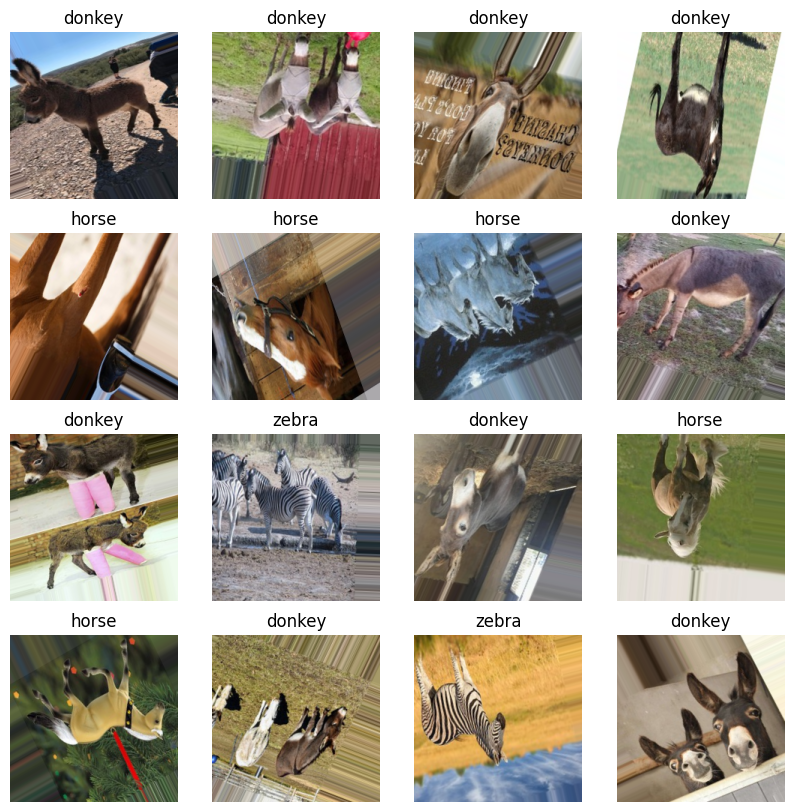

In [15]:
# Preview of Training Dataset
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i])
  label = np.argmax(label_batch[i])
  plt.title(class_names[label])
  plt.axis("off")

### Define Model And Train Model

In [24]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=image_size + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+image_size+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              5919312   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 5923155 (22.60 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [25]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy']
  )

In [26]:
epochs = 5
history = model.fit(
      train_ds,
      epochs=epochs,
      validation_data=val_ds,
      verbose=2
      )

Epoch 1/5
78/78 - 26s - loss: 1.6781 - accuracy: 0.7829 - val_loss: 0.9538 - val_accuracy: 0.9486 - 26s/epoch - 337ms/step
Epoch 2/5
78/78 - 19s - loss: 1.1649 - accuracy: 0.8467 - val_loss: 0.7514 - val_accuracy: 0.9465 - 19s/epoch - 246ms/step
Epoch 3/5
78/78 - 19s - loss: 1.3053 - accuracy: 0.8378 - val_loss: 0.7723 - val_accuracy: 0.9321 - 19s/epoch - 242ms/step
Epoch 4/5
78/78 - 19s - loss: 1.5980 - accuracy: 0.8111 - val_loss: 0.7959 - val_accuracy: 0.9630 - 19s/epoch - 245ms/step
Epoch 5/5
78/78 - 19s - loss: 1.6175 - accuracy: 0.8257 - val_loss: 1.0407 - val_accuracy: 0.9383 - 19s/epoch - 244ms/step


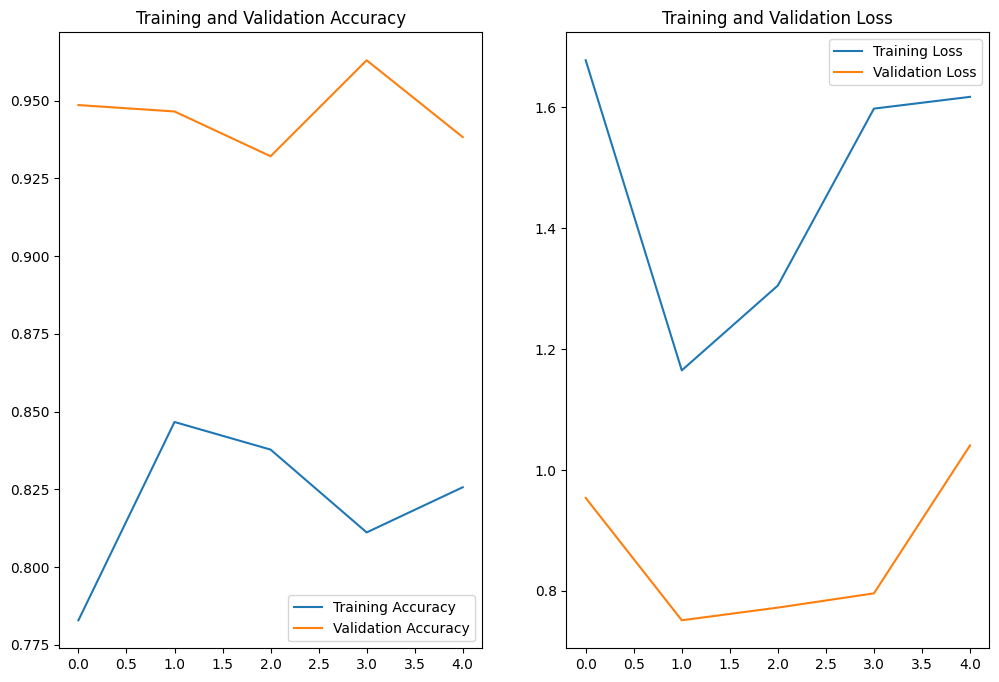

In [27]:
# Visualize Model Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluate The Model with Test Data

In [28]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.,)
test_ds = test_datagen.flow_from_directory(
    directory=data_test_dir,
    batch_size=batch_size,
    class_mode="categorical",
    target_size=image_size
    )

Found 353 images belonging to 3 classes.


In [29]:
# Get image that want to predict
print("Evaluation")
loss, acc = model.evaluate(test_ds)
print("loss: ", loss)
print("acc: ", acc)

Evaluation
23/23 [==============================] - 3s 106ms/step - loss: 1.0450 - accuracy: 0.9462
loss:  1.0450356006622314
acc:  0.9461756348609924


## Predict Test Data

In [33]:
# Predict image
def print_prediction(img_path, model_ml):
  # Convert image for input tensorflow
  img = image.load_img(img_path, target_size=(224, 224))
  imgplot = plt.imshow(img)
  plt.axis("off")
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0  # Normalize image

  # Predict image
  predictions = class_names[np.argmax(model_ml.predict(x))]
  plt.title(predictions)

Actual: zebra
1/1 [==============================] - 0s 63ms/step


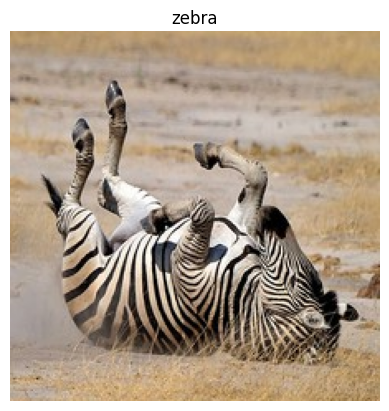

In [34]:
choosen_category = class_names[random.randrange(num_classes)]
category_dir = os.path.join(data_test_dir, choosen_category)
choosen_image = os.listdir(category_dir)[random.randrange(len(os.listdir(category_dir)))]
choosen_image_dir = os.path.join(category_dir, choosen_image)
print("Actual:", choosen_category)
print_prediction(choosen_image_dir, model)